# Implementing Vi(sual)T(transformer) in PyTorch

그림은 ViT의 아키텍쳐를 보여줌  


![alt](https://github.com/FrancescoSaverioZuppichini/ViT/blob/main/images/ViT.png?raw=true)

이미지는 16x16 flattem patches로 분해됨(이미지 크기는 조정되지 않음). 그런 다음 flatten patche들은 normal fully connected layer에 들어가고, Bert의 [CLS] 토큰과 같은 `cls` 이 앞에 추가되고 `positional encoding` 이 더해짐. 결과 텐서는 standard Transfomer에 전달되고 classification head에 전달됨.  

구조는 다음과 같이 구성됨  

- Data
- Patches Embeddings
    - CLS Token
    - Position Embedding
- Transformer
    - Attention
    - Residuals
    - MLP
    - TransformerEncoder
- Head
- ViT

저자는 모델 블록 구현을 상향식 접근 방법으로 구현 할 것임. 우선 필요한 패키지 부터 가져오자

In [10]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary


## Data

우성 이미지가 필요함. 귀여운 고양이면 됨

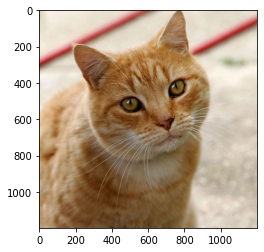

In [11]:
img = Image.open('./cat.jpg')

fig = plt.figure()
plt.imshow(img)

![alt](https://github.com/FrancescoSaverioZuppichini/ViT/blob/main/images/output_5_1.png?raw=true)

그리고 전처리를 해야함

In [12]:
# resize to imagenet size 
transform = Compose([Resize((224, 224)), ToTensor()])
x = transform(img)
x = x.unsqueeze(0) # add batch dim
x.shape

torch.Size([1, 3, 224, 224])

## Patches Embeddings

첫 단계는 이미지를 여러 패치로 나누고 그것을 flatten 하는 것임:  

![alt](https://github.com/FrancescoSaverioZuppichini/ViT/blob/main/images/Patches.png?raw=true)

논문 인용:

![alt](https://github.com/FrancescoSaverioZuppichini/ViT/blob/main/images/paper1.png?raw=true)


einops로 이것을 더 편하게 할 수 있음

In [13]:
print("Before x: ", x.shape, "\n")
patch_size = 16 # 16 pixels
pathes = rearrange(x, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)
print("pathes: rearrange x")
print(pathes.shape)

Before x:  torch.Size([1, 3, 224, 224]) 

pathes: rearrange x
torch.Size([1, 196, 768])


이제 우리는 이것을 normal linear layer로 project 시켜야함

![alt](https://github.com/FrancescoSaverioZuppichini/ViT/blob/main/images/PatchesProjected.png?raw=true)

위의 코드들을 `PatchEmbedding` 클래스를 만들어 코드를 깔끔하게 유지 가능 함

In [14]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # break-down the image in s1 x s2 patches and flat them
            Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )
                
    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        return x
    
PatchEmbedding()(x).shape

torch.Size([1, 196, 768])

**Note** 원본 구현을 확인한 후, 저자들이 성능향상을 위해 선형층 대신 Conv2d 층을 사용하다는 것을 알았고, kernel_size와 stride를 같게 하여 `patch_size` 처럼 나누는 효과를 얻게 함. 직관적으로 컨볼루션 연산은 각 패치에 개별적으로 작용함. 그래서 먼저 conv layer를 적용하고 결과 이미지를 flat 시킴

In [19]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
                
    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        return x
    
PatchEmbedding()(x).shape

torch.Size([1, 196, 768])

### CLS Token

다음 단계는 `cls token`과 포지션 임베딩을 더해주는 것임.  
`cls token`는 **각**시퀸스에 배치된 숫자임   
`repeat`를 사용해 

In [24]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        # cls_token을 반복하여 배치사이즈의 크기와 맞춰줌
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        return x
    
PatchEmbedding()(x).shape

torch.Size([1, 197, 768])

`cls_token`는 랜덤으로 초기화된 torch Parameter고, forward 함수에서 `b` (batch)번 복사한 후 projected patches앞에 붙임

### Position Embedding

So far, the model has no idea about the original position of the patches. We need to pass this spatial information. This can be done in different ways, in ViT we let the model learn it. The position embedding is just a tensor of shape `N_PATCHES + 1 (token), EMBED_SIZE` that is added to the projected patches.

지금까지 모델은 패치의 원래 position을 알지 못 했음. 그래서 공간 정보를 넣어줘야 함. 이건 여러 방식으로 수행할 수 있는데, ViT에서는 모델이 학습하도록 할 것임. Position Embedding은 projected patches에 추가될 `N_PATCHES + 1 (token), EMBED_SIZE` 크기의 텐서임.

In [26]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, img_size: int = 224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))

        
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        # add position embedding
        x += self.positions
        return x
    
PatchEmbedding()(x).shape

torch.Size([1, 197, 768])

`.positions`field에 position embedding을 추가해 주었고, 이를 `.forward` function에서 패치해 더해주었음

## Transformer

이제 Transforemr를 구현해야함. ViT에서는 Encoder만 사용함. 아키텍쳐는 아래와 같음   
<img src="https://github.com/FrancescoSaverioZuppichini/ViT/blob/main/images/TransformerBlock.png?raw=true" alt="drawing" width="200"/>

Attention 부터 시작해 봅시다

### Attention

Attention에는 세개의 inputs이 들어감. 바로 queries, keys, values임, 그리고 queries와 values를 사용하여 attention matrix을 계산하고, "attend"로서 값으로 사용함.  
이 때, multi-head attention을 사용하는데 n개의 head로 분할해 더 작은 input size를 갖게 하여 계산하는 것임. transformer이론 에서 나왔듯이 이건 여러 시각에서 바라 볼 수 있게함.  
![alt](https://github.com/FrancescoSaverioZuppichini/ViT/blob/main/images/TransformerBlockAttention.png?raw=true)

파이토치에서 `nn.MultiHadAttention`를 사용할수 있지만 완성도를 높히기 위해 자체구현을 함

In [27]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        self.scaling = (self.emb_size // num_heads) ** -0.5

    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        values  = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        att = F.softmax(energy, dim=-1) * self.scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out
    
patches_embedded = PatchEmbedding()(x)
MultiHeadAttention()(patches_embedded).shape

torch.Size([1, 197, 768])

queries, keys, values, 그리고 마지막 dropout을 위한 4개의 fully connected layer가 있음.  
  
아이디어는 (읽어주세요 [The Illustrated Transformer
](https://jalammar.github.io/illustrated-transformer/)) queries와 keys를 product하여 각 element가 시퀸스의 나머지 elemet에 '얼마나'중요한지를 알아내는 것임. Then, we use this information to scale the values(행렬곱 한다는 의미).  
  
`forward` 메서드는 이전 layer의 queries, key, 그리고 values를 입력으로 사용하고, 3개의 linear layer를 사용하여 projection함. 그리고 이후에 multi heads attention을 구현할거기 대문에 result를 multiple heads로 재배열 함.   
  
einops의 `rearrange`로 이것을 구현 할 것임  

*Queries, Keys 그리고 Values*는 항상 같음. 간결함을 위해 input으로는 `x`하나만 사용 할 것임.  

```python
queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.n_heads)
keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.n_heads)
values  = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.n_heads)
```

결과로 나온 Queries, Keys, Values의 shape는 `BATCH, HEADS, SEQUENCE_LEN, EMBEDDING_SIZE`임.  
attention matrix를 계산하기 위해 우선 queries와 key의 행렬곱 연산을 수행하해야함. sum up over the last axis.라고 부르는데 `torch.einsum`를 사용  

```python
energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys
```

결과 벡터의 shape로는 `BATCH, HEADS, QUERY_LEN, KEY_LEN`임. 그런 다음 attention은 embedding의 사이즈를 베이스로한 scaling factor로 나는 resulting vactor를 softmax함  
마지막으로 attention to scale the values함  

```python
torch.einsum('bhal, bhlv -> bhav ', att, values)
```

그러면 우리는 `BATCH HEADS VALUES_LEN, EMBEDDING_SIZE` 크기의 벡터를 얻음. 우리는 heads들을 concat하고 결과를 반환함  

**Note** single matrix로 `queries, keys and values` 한번에 계산할 수 있움

In [30]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out
    
patches_embedded = PatchEmbedding()(x)
MultiHeadAttention()(patches_embedded).shape

torch.Size([1, 197, 768])

### Residuals

이 transformer block은 residual connection임

![alt](https://github.com/FrancescoSaverioZuppichini/ViT/blob/main/images/TransformerBlockAttentionRes.png?raw=true)

residual connection를 수행하기 위해 구현한 클래스, 나중에 fn을 입력받아 fn의 forward 후 res를 더해 사용하게 됨.

In [31]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

## MLP

attention의 ouput은 fully connected layer(`expansion`를 input으로 받는 upsamle하는 두개의 레이어)를 통과하게 됨  
<img src="https://github.com/FrancescoSaverioZuppichini/ViT/blob/main/images/TransformerBlockAttentionZoom.png?raw=true" alt="drawing" width="200"/>


In [32]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

**드디어**, Transformer Encoder Block을 만들 수 있슴  
<img src="https://github.com/FrancescoSaverioZuppichini/ViT/blob/main/images/TransformerBlock.png?raw=true" alt="drawing" width="200"/>


`ResidualAdd` 을 사용하면 이 블록을 이쁘게 만들 수 있음

In [33]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

테스트 해 보자

In [35]:
patches_embedded = PatchEmbedding()(x)
TransformerEncoderBlock()(patches_embedded).shape

torch.Size([1, 197, 768])

Pytorch의 내장형 multi-head attention도 사용 가능하지만 queries, keys, and values 3개의 inputs이 요구됨. You can subclass it and pass the same input

### Transformer

ViT에서는 transformer의 Encoder 파트만 사용됨. 간단하게, 인코터 `TransformerBlock`를 `L`라고 명침함


In [38]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])
                

## Head

마지막 layer는 class probability를 제공해주는 normal fully connect layer임. It first performs a basic mean over the whole sequence.

In [39]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, n_classes))

## Vi(sual) T(rasnformer)

최종의 ViT 아키텍처를 만들기 위해 `PatchEmbedding`, `TransformerEncoder` and  `ClassificationHead`를 구성함.

In [40]:
class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 224,
                depth: int = 12,
                n_classes: int = 1000,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )
        

We can use `torchsummary` to check the number of parameters

In [41]:
summary(ViT(), (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
         Rearrange-2             [-1, 196, 768]               0
    PatchEmbedding-3             [-1, 197, 768]               0
         LayerNorm-4             [-1, 197, 768]           1,536
            Linear-5            [-1, 197, 2304]       1,771,776
           Dropout-6          [-1, 8, 197, 197]               0
            Linear-7             [-1, 197, 768]         590,592
MultiHeadAttention-8             [-1, 197, 768]               0
           Dropout-9             [-1, 197, 768]               0
      ResidualAdd-10             [-1, 197, 768]               0
        LayerNorm-11             [-1, 197, 768]           1,536
           Linear-12            [-1, 197, 3072]       2,362,368
             GELU-13            [-1, 197, 3072]               0
          Dropout-14            [-1, 19

끝

```
================================================================
Total params: 86,415,592
Trainable params: 86,415,592
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 364.33
Params size (MB): 329.65
Estimated Total Size (MB): 694.56
---------------------------------------------------------------
```

Ref: [ViT](https://github.com/FrancescoSaverioZuppichini/ViT)